In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import scipy as sp
import os

In [2]:
sns.set(font_scale=1.5)

In [3]:
# Raman spectrum class
class raman_spectrum:
    def __init__(self,fname):
        self.fname = fname
        self.fname0 = self.fname.split('/')[-1]
        self.df = pd.read_csv(fname + '.tsv', sep='\t', header =7)
        self.df.rename(columns={'Wavenumber [cm^-1]':'Raman Shift, cm-1', 'Raman [%]':'Intensity, %'}, inplace = True)
        self.df.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.df.dropna(inplace = True)
        
    def plot(self, color, label):
        sns.lineplot(self.df, x = "Raman Shift, cm-1", y = "Intensity, %", color = color, label = label)
        plt.xlabel(r'Raman Shift, $cm^{-1}$') 

In [4]:
home_dir = "C:/Users/ya/"
dir_path = home_dir + "Data/miniRaman_test_reports/10022/"

In [5]:
f = dir_path + 'calcite_250ms_70mW_785nm_Data'
s_calcite_785  = raman_spectrum(f)

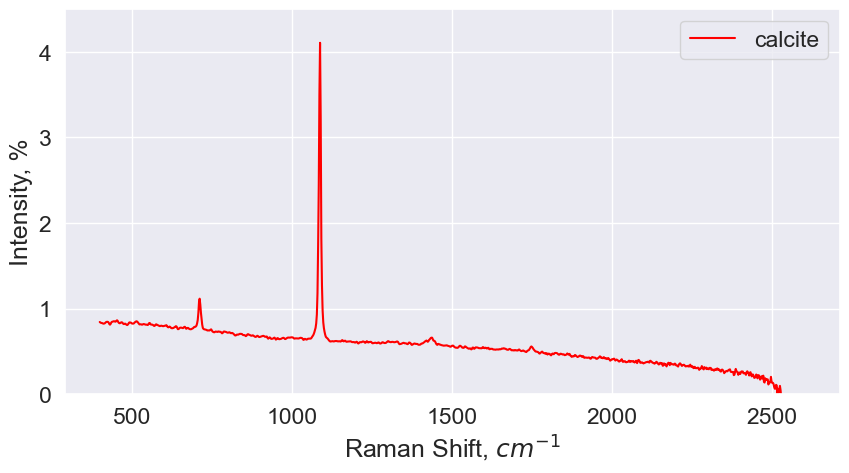

In [6]:
plt.figure(figsize = (10,5))
s_calcite_785.plot('red','calcite')
plt.ylim(0,4.5)
plt.savefig('calcite_785.png', dpi =300, bbox_inches='tight')

In [7]:
df_calcite_1 = s_calcite_785.df[s_calcite_785.df["Raman Shift, cm-1"].between(1055,1125, inclusive = 'both')]

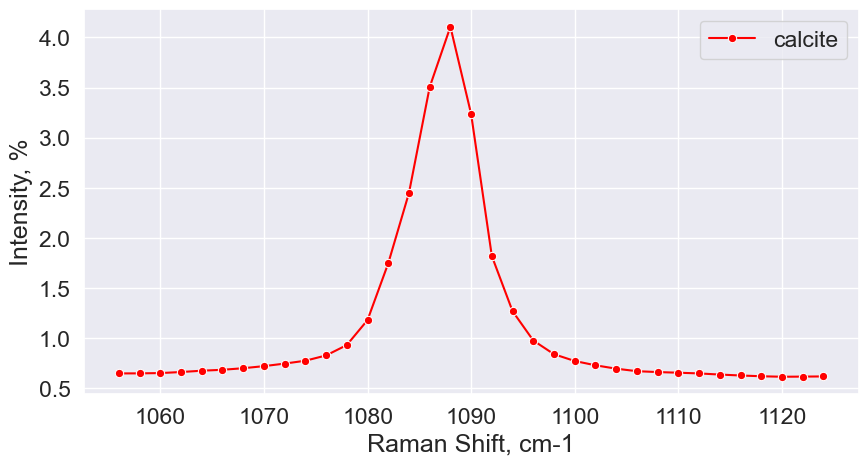

In [8]:
plt.figure(figsize = (10,5))
sns.lineplot(df_calcite_1, x = "Raman Shift, cm-1", y = "Intensity, %", marker ="o", color = 'red', label = 'calcite')
plt.savefig('calcite_01.png', dpi =300, bbox_inches='tight')

In [9]:
x1 = np.arange(df_calcite_1["Raman Shift, cm-1"].min(),df_calcite_1["Raman Shift, cm-1"].max(),0.1)

In [10]:
def gauss(x, A0, A, x0, sigma):
    return A0 + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [11]:
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [12]:
popt1 = gauss_fit(df_calcite_1["Raman Shift, cm-1"],df_calcite_1["Intensity, %"])

In [13]:
y1 = gauss(x1, *popt1)

In [14]:
df_fit_gauss = pd.DataFrame()
df_fit_gauss["Raman Shift, cm-1"] = x1.tolist()
df_fit_gauss["Intensity, %"] = y1.tolist()

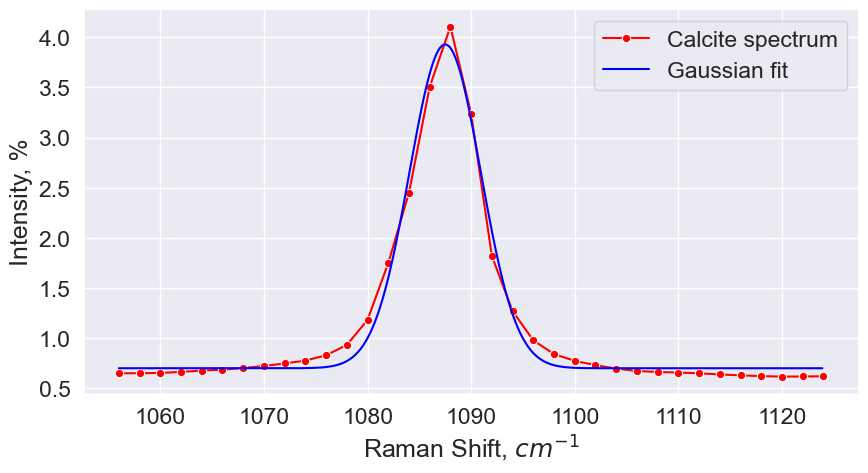

In [15]:
plt.figure(figsize = (10,5))
sns.lineplot(df_calcite_1, x = "Raman Shift, cm-1", y = "Intensity, %", marker ="o", color = 'red', label = "Calcite spectrum")
sns.lineplot(df_fit_gauss, x = "Raman Shift, cm-1", y = "Intensity, %", color = 'blue', label = "Gaussian fit")
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_gauss_fit.png', dpi =300, bbox_inches='tight')

In [16]:
popt1

array([ 6.98112860e-01,  3.22987258e+00,  1.08749499e+03, -3.43820373e+00])

In [17]:
#FWHM
2*np.sqrt(2*np.log(2))*abs(popt1[3])

8.09635106783667

In [18]:
def lorentz( x, A0, A, x0, gamma ):
    return A0 + A * gamma**2 / ( gamma**2 + ( x - x0 )**2)

In [19]:
p0 = [0, 4, 1085, 1]

def lorentz_fit(x, y):
    popt, pcov = curve_fit(lorentz, x, y, p0=p0)
    return popt

In [20]:
popt2 = lorentz_fit(df_calcite_1["Raman Shift, cm-1"],df_calcite_1["Intensity, %"])

In [21]:
y2 = lorentz(x1, *popt2)

In [22]:
df_fit_lorentz = pd.DataFrame()
df_fit_lorentz["Raman Shift, cm-1"] = x1.tolist()
df_fit_lorentz["Intensity, %"] = y2.tolist()

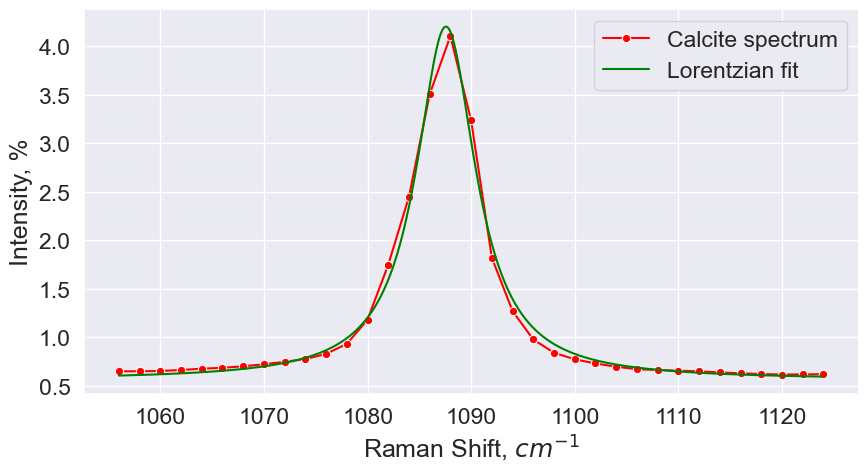

In [23]:
plt.figure(figsize = (10,5))
sns.lineplot(df_calcite_1, x = "Raman Shift, cm-1", y = "Intensity, %", marker ="o", color = 'red', label = "Calcite spectrum")
sns.lineplot(df_fit_lorentz, x = "Raman Shift, cm-1", y = "Intensity, %", color = 'green', label = "Lorentzian fit")
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_lorentz_fit.png', dpi =300, bbox_inches='tight')

In [24]:
popt2

array([5.59810395e-01, 3.64307860e+00, 1.08757145e+03, 3.50122498e+00])

In [25]:
#FWHM
2*popt2[3]

7.00244995329159

In [26]:
from scipy.special import wofz

In [27]:
def voigt(x, A0, A, x0, sigma, gamma):
    return A0 + A * np.real(wofz((x - x0 + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

In [28]:
p0 = [0, 4, 1085, 2,2]

In [29]:
def voigt_fit(x, y):
    popt, pcov = curve_fit(voigt, x, y, p0=p0)
    return popt

In [30]:
popt3 = voigt_fit(df_calcite_1["Raman Shift, cm-1"],df_calcite_1["Intensity, %"])

In [31]:
y3 = voigt(x1, *popt3)

In [32]:
df_fit_voigt = pd.DataFrame()
df_fit_voigt["Raman Shift, cm-1"] = x1.tolist()
df_fit_voigt["Intensity, %"] = y3.tolist()

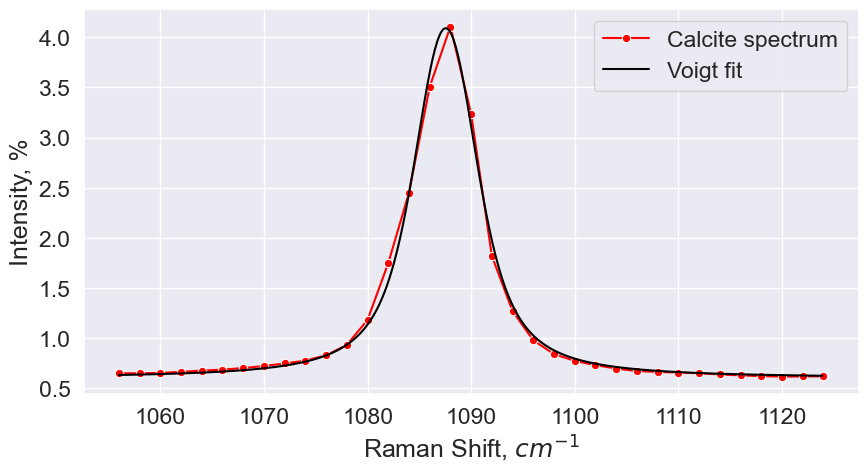

In [33]:
plt.figure(figsize = (10,5))
sns.lineplot(df_calcite_1, x = "Raman Shift, cm-1", y = "Intensity, %", marker ="o", color = 'red', label = "Calcite spectrum")
sns.lineplot(df_fit_voigt, x = "Raman Shift, cm-1", y = "Intensity, %", color = 'black', label = "Voigt fit")
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_voigt_fit.png', dpi =300, bbox_inches='tight')

In [34]:
popt3

array([6.01007330e-01, 3.63298344e+01, 1.08754782e+03, 1.72334849e+00,
       2.55363910e+00])

In [35]:
fL = 2*popt3[4]
fL

5.107278207662339

In [36]:
fG = 2*np.sqrt(2*np.log(2))*popt3[3]
fG

4.058175560194967

In [37]:
f_Voigt = 0.5346 * fL  + np.sqrt( 0.2166 * fL**2 + fG**2)
f_Voigt

7.433397414906343

In [38]:
resolution = (f_Voigt - 0.684)/1.0209
resolution

6.61122285719105

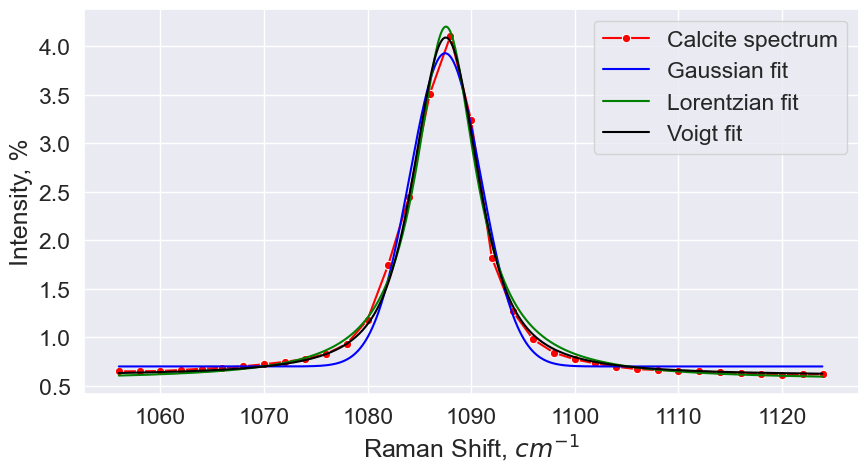

In [39]:
# plot all
plt.figure(figsize = (10,5))
sns.lineplot(df_calcite_1, x = "Raman Shift, cm-1", y = "Intensity, %", marker ="o", color = 'red', label = "Calcite spectrum")
sns.lineplot(df_fit_gauss, x = "Raman Shift, cm-1", y = "Intensity, %", color = 'blue', label = "Gaussian fit")
sns.lineplot(df_fit_lorentz, x = "Raman Shift, cm-1", y = "Intensity, %", color = 'green', label = "Lorentzian fit")
sns.lineplot(df_fit_voigt, x = "Raman Shift, cm-1", y = "Intensity, %", color = 'black', label = "Voigt fit")
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_fit_all.png', dpi =300, bbox_inches='tight')

In [40]:
error1 = pd.DataFrame()
error1["Raman Shift, cm-1"] = df_calcite_1["Raman Shift, cm-1"]
error1["Error, %"] =  gauss(df_calcite_1["Raman Shift, cm-1"], *popt1) - df_calcite_1["Intensity, %"]

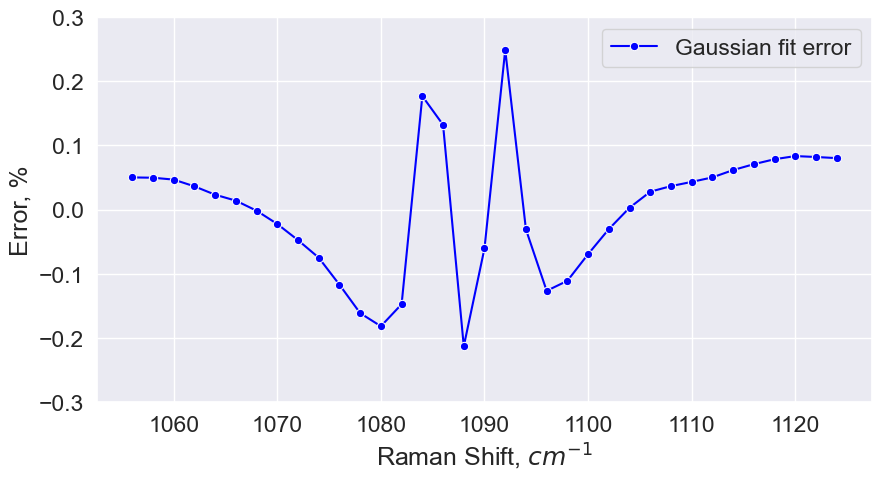

In [41]:
plt.figure(figsize = (10,5))
sns.lineplot(error1, x = "Raman Shift, cm-1", y = "Error, %", marker ="o", color = 'blue', label = "Gaussian fit error")
plt.ylim(-0.3,0.3)
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_gauss_fit_error.png', dpi =300, bbox_inches='tight')

In [42]:
chi2_gauss = np.sum(error1["Error, %"]**2)/error1["Error, %"].size

In [43]:
chi2_gauss

0.009955851734696885

In [44]:
error2 = pd.DataFrame()
error2["Raman Shift, cm-1"] = df_calcite_1["Raman Shift, cm-1"]
error2["Error, %"] =  lorentz(df_calcite_1["Raman Shift, cm-1"], *popt2) - df_calcite_1["Intensity, %"]

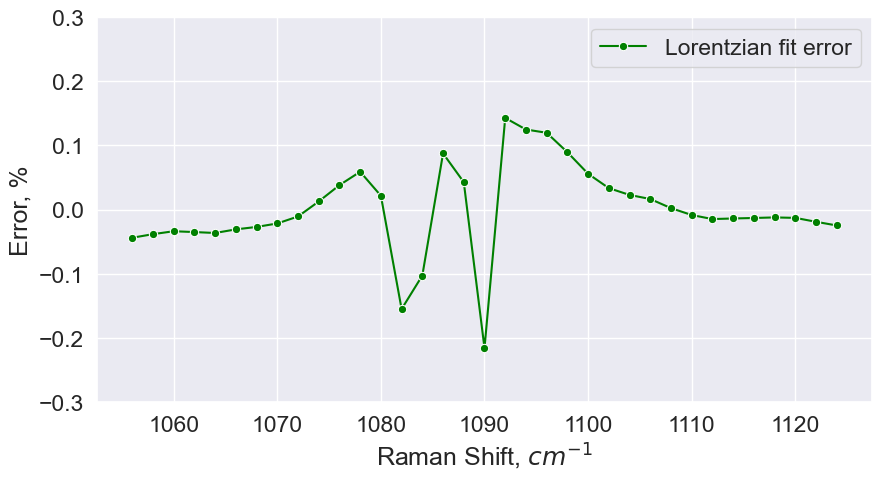

In [53]:
plt.figure(figsize = (10,5))
sns.lineplot(error2, x = "Raman Shift, cm-1", y = "Error, %", marker ="o", color = 'green', label = "Lorentzian fit error")
plt.ylim(-0.3,0.3)
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_lorentz_fit_error.png', dpi =300, bbox_inches='tight')

In [46]:
chi2_lorentz = np.sum(error2["Error, %"]**2)/error2["Error, %"].size

In [47]:
chi2_lorentz

0.004882272418488386

In [48]:
error3 = pd.DataFrame()
error3["Raman Shift, cm-1"] = df_calcite_1["Raman Shift, cm-1"]
error3["Error, %"] =  voigt(df_calcite_1["Raman Shift, cm-1"], *popt3) - df_calcite_1["Intensity, %"]

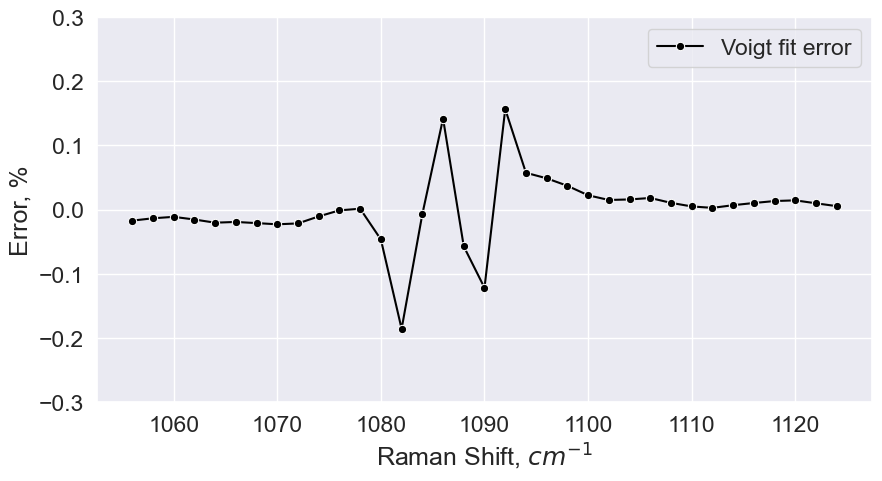

In [54]:
plt.figure(figsize = (10,5))
sns.lineplot(error3, x = "Raman Shift, cm-1", y = "Error, %", marker ="o", color = 'black', label = "Voigt fit error")
plt.ylim(-0.3,0.3)
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_voigt_fit_error.png', dpi =300, bbox_inches='tight')

In [50]:
chi2_voigt = np.sum(error3["Error, %"]**2)/error3["Error, %"].size

In [51]:
chi2_voigt

0.0031965457618039566

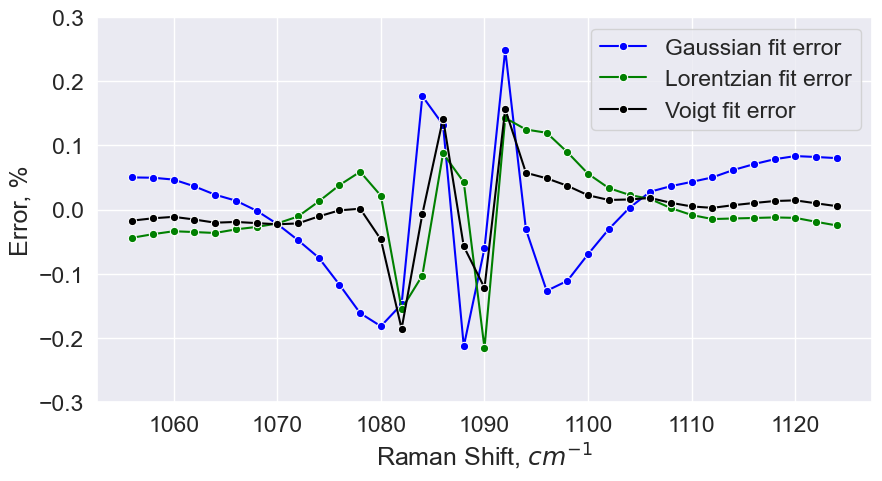

In [52]:
# plot all fits together

plt.figure(figsize = (10,5))
sns.lineplot(error1, x = "Raman Shift, cm-1", y = "Error, %", marker ="o", color = 'blue', label = "Gaussian fit error")
sns.lineplot(error2, x = "Raman Shift, cm-1", y = "Error, %", marker ="o", color = 'green', label = "Lorentzian fit error")
sns.lineplot(error3, x = "Raman Shift, cm-1", y = "Error, %", marker ="o", color = 'black', label = "Voigt fit error")
plt.ylim(-0.3,0.3)
plt.xlabel(r'Raman Shift, $cm^{-1}$')
plt.savefig('calcite_fit_error_all.png', dpi =300, bbox_inches='tight')
